# Evaluation and Comparison of Boosted ML Models in Behavior-Based Malware Detection


## Notebook: CatBoost Training

***

**What is the objective of this file?**

To train the model using the Train Split (Statically Split).

## Checklist

- Ensure that you have the proper dataset files that you intend to use (i.e., whether the lite dataset or full version). 
    - The datasets it will use points to `/Official Development/Dataset/IB` & `/Official Development/Dataset/TB`. 
    - You can run the `/Official Development/Dataset [OFFICIAL] Oliveira Dataset Notebook.ipynb file` or unzip one of the zipped folders in the `/Official Development/Dataset/Processed` towards the two aforementioned folders. 
- Ensure that you have installed the necessary libraries needed to execute the training process. 
    - You can view the list of the specific versions in the thesis document or through the `.sh` or `.bat` files in the repository's home directory.

# 1. CatB Training Setup

Setting training environment parameters.

## 1.0. Tuning Settings

1. What will the output filename be?
2. Will you train a tuned model?
3. What hyperparameter values will you use?

For no. 3, the value looks like
`{'task_type': 'CPU', 'objective': 'Logloss', 'n_estimators': 50, 'max_depth': 11, 'learning_rate': 0.1, 'l2_leaf_reg': 2, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered', 'auto_class_weights': 'Balanced'}`
which is obtained as part of the results of the associated tuning file to this file.

Alternatively, you can just point a file directly to it (overrides the manual setup if not empty).

**Do not include the custom hyperparameter values for `random_state`, `thread_count`, `verbose`, `cat_features`, and `nan_mode` as the values for these are hardcoded to the notebook.**

In [1]:
MODEL_FILENAME = "RYZEN" # <== Set the prefix for the filename of the output file (don't include file extension)
TUNED_TRAINING = True # <== Set as True if you'll be training a tuned model.

# These parameters are mostly default valued parameters for CatBoost except some that are mentioned in the paper (e.g., Ordered Boosting, Symmeteric Tree); Set as None for truly defaults.
TB_HYPERPARAMS = "{'task_type': 'GPU'}" # None or like "{'task_type': 'CPU', 'objective':'Logloss', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered'}"
IB_HYPERPARAMS = "{'task_type': 'GPU'}" # None or like "{'task_type': 'CPU', 'objective':'Logloss', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered'}"

TB_HYPERPARAMS_FILE = "./Outputs/Results/Ryzen/CATB/Tuning/RYZEN_CATB_TB.tune" # <== Empty string or Pointing a .tune file overrides the value set above.
IB_HYPERPARAMS_FILE = "./Outputs/Results/Ryzen/CATB/Tuning/RYZEN_CATB_IB.tune" # <== Empty string or Pointing a .tune file overrides the value set above.

STATIC_SPLIT = 0.3 # <== To achieve the 70:30 Static Split
RANDOM_SEED = 1 # <== Must be the same throughout the entire study (acts as a controlled variable), hence let's just settle with 1.

# ⚠️Warning

**Be careful of modifying the code beyond this point as it was designed to run autonomously based on the parameters set above.**

## 1.1. Loading Libraries

In [2]:
#Python Libraries
import time
from datetime import datetime
import json

#Data/Dataset Libraries
import pandas as pd
import numpy as np

#Model Selection
from sklearn.model_selection import train_test_split

#Metrics (for in-training testing only)
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, roc_auc_score

#Visualization
from matplotlib import pyplot as plt

#GBDT Models
# import lightgbm
import catboost

#File Writing Library (exclusive for use on LightGBM)
from joblib import dump, load

## 1.2. Logging and Diagnostics

In [3]:
if TUNED_TRAINING:
    MODEL_FILENAME = "TUNED_" + MODEL_FILENAME
    if len(TB_HYPERPARAMS_FILE) != 0:
        f = open(TB_HYPERPARAMS_FILE, "r")
        TB_HYPERPARAMS = f.readline()
        f.close()
    if len(IB_HYPERPARAMS_FILE) != 0:
        f = open(IB_HYPERPARAMS_FILE, "r")
        IB_HYPERPARAMS = f.readline()
        f.close()
    TB_HYPERPARAMS = TB_HYPERPARAMS.replace('\'', '\"')#.replace("False", "\"False\"").replace("True", "\"True\"")
    TB_HYPERPARAMS = json.loads(str(TB_HYPERPARAMS))
    print("Parsed TB Hyperparams:", TB_HYPERPARAMS)
    print("")
    IB_HYPERPARAMS = IB_HYPERPARAMS.replace('\'', '\"')#.replace("False", "\"False\"").replace("True", "\"True\"")
    IB_HYPERPARAMS = json.loads(str(IB_HYPERPARAMS))
    print("Parsed IB Hyperparams:", IB_HYPERPARAMS)
else:
    if TB_HYPERPARAMS != None:
        TB_HYPERPARAMS = TB_HYPERPARAMS.replace('\'', '\"').replace("False", "\"False\"").replace("True", "\"True\"")
        TB_HYPERPARAMS = json.loads(str(TB_HYPERPARAMS))
    else:
        TB_HYPERPARAMS = None
    if IB_HYPERPARAMS != None:
        IB_HYPERPARAMS = IB_HYPERPARAMS.replace('\'', '\"').replace("False", "\"False\"").replace("True", "\"True\"")
        IB_HYPERPARAMS = json.loads(str(IB_HYPERPARAMS))
    else:
        IB_HYPERPARAMS = None

start = end = 0
LOG_FILENAME = "CATB_Training_Log.txt"
def logging(message):
    log = open(LOG_FILENAME, "a")
    log.write(message)
    log.close()
def start_time():
    global start
    start = time.time()
def end_time(process):
    global start
    elapse = time.time()-start
    start = 0
    printout = f"{str(datetime.now())}@{MODEL_FILENAME}: {process} - {round(elapse, 6)}s\n"
    logging(printout)
    return round(elapse, 6)

Parsed TB Hyperparams: {'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'gpu_cat_features_storage': 'CpuPinnedMemory', 'grow_policy': 'SymmetricTree', 'l2_leaf_reg': 1, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 250, 'objective': 'Logloss', 'task_type': 'GPU'}

Parsed IB Hyperparams: {'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'gpu_cat_features_storage': 'CpuPinnedMemory', 'grow_policy': 'SymmetricTree', 'l2_leaf_reg': 1, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 250, 'objective': 'Logloss', 'task_type': 'GPU'}


## 1.3. Loading Datasets

Note that it will use the files in `/Official Development/Dataset/IB` & `/Official Development/Dataset/TB`. 

### 1.3.1. Setting filenames

In [4]:
#Setting filenames of files
TB_Train = "../Dataset/TB/CATB_TB.csv" # <== Location for Time-based Train Split for CatBoost
#TB_Test = "../Dataset/TB/TB_Test_CATB.csv" # <== Location for Time-based Test Split for CatBoost
IB_Train = "../Dataset/IB/CATB_IB.csv" # <== Location for Instance-based Train Split for CatBoost
#IB_Test = "../Dataset/IB/IB_Test_CATB.csv" # <== Location for Instance-based Test Split for CatBoost

### 1.3.2. Loading datasets to DataFrames

In [5]:
#Loading datasets to DataFrames
tb_train = pd.read_csv(TB_Train, low_memory=False).fillna("NaN")
ib_train = pd.read_csv(IB_Train, low_memory=False).fillna("NaN")

print("Dataset Sizes")
print("TB Train Size:", tb_train.shape)
print("IB Train Size:", ib_train.shape)

Dataset Sizes
TB Train Size: (77026, 101)
IB Train Size: (77026, 101)


### 1.3.3. Previewing datasets

In [6]:
#Previewing Time-based Dataset
tb_train.head()

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,1,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,...,LdrGetProcedureAddress,LookupAccountSidW,LdrGetProcedureAddress,LookupAccountSidW,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress
1,1,NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,LdrGetDllHandle,LdrGetProcedureAddress,...,FindResourceExW,LoadResource,FindResourceExW,LoadResource,LdrGetDllHandle,LdrGetProcedureAddress,LoadStringW,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle
2,1,NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,LdrGetDllHandle,LdrGetProcedureAddress,...,FindResourceExW,LoadResource,FindResourceExW,LoadResource,LdrGetDllHandle,LdrGetProcedureAddress,LoadStringW,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle
3,0,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,...,SetFilePointer,NtReadFile,SetFilePointer,NtReadFile,SetFilePointer,NtReadFile,SetFilePointer,NtReadFile,SetFilePointer,NtReadFile
4,1,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,...,LoadResource,FindResourceExW,LoadResource,FindResourceExW,LoadResource,OleInitialize,FindResourceExW,LoadResource,FindResourceExW,LoadResource


In [7]:
#Previewing Instance-based Dataset
ib_train.head()

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,1,LdrLoadDll,LdrGetProcedureAddress,NtProtectVirtualMemory,NtClose,NtOpenKey,NtQueryValueKey,LdrGetDllHandle,GetSystemInfo,NtAllocateVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NtClose,NtOpenKey,NtQueryValueKey,LdrGetDllHandle,LdrGetProcedureAddress,GetSystemInfo,NtAllocateVirtualMemory,RegOpenKeyExW,FindFirstFileExW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,NtClose,NtOpenKey,NtQueryValueKey,LdrGetDllHandle,LdrGetProcedureAddress,GetSystemInfo,NtAllocateVirtualMemory,RegOpenKeyExW,FindFirstFileExW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,LdrLoadDll,LdrGetProcedureAddress,NtProtectVirtualMemory,GetSystemTimeAsFileTime,SetUnhandledExceptionFilter,GetSystemInfo,NtAllocateVirtualMemory,RegOpenKeyExW,RegQueryValueExW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,LdrLoadDll,LdrGetProcedureAddress,NtProtectVirtualMemory,NtClose,NtOpenKey,NtQueryValueKey,LdrGetDllHandle,GetSystemInfo,NtAllocateVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.3.4. Statically Splitting the Train Split

Train Split --> Training and Validation Split

However only Training Split will be used.

In [8]:
#Static splitting of Train Split of Time-based
X_tb = tb_train.iloc[:,1:101] #All rows, 2nd to last column
y_tb = tb_train.iloc[:,0] #All rows, first column only
X_tb_training, X_tb_validate, y_tb_training, y_tb_validate = train_test_split(X_tb, y_tb, test_size=STATIC_SPLIT, shuffle=True, random_state=1)

#Static splitting of Train Split of Instance-based
X_ib = ib_train.iloc[:,1:101] #All rows, 2nd to last column
y_ib = ib_train.iloc[:,0] #All rows, first column only
X_ib_training, X_ib_validate, y_ib_training, y_ib_validate = train_test_split(X_ib, y_ib, test_size=STATIC_SPLIT, shuffle=True, random_state=1)

# 2. Model Training

## 2.1. Setting up the Model

In [9]:
def get_indexes():
    indexes = []
    for i in range(100):
        indexes.append(f"t_{i}")
    return indexes

def setup_model(HYPERPARAMS, TYPE):
    global TUNED_TRAINING
    indexes = get_indexes()
    metric=['Logloss', 'AUC', 'Precision']
    train_dir = f"Outputs/CATB/{MODEL_FILENAME}_CATB_{TYPE}_TRAINDIR"
    if HYPERPARAMS == None:
        return catboost.CatBoostClassifier(random_state=RANDOM_SEED, thread_count=-1, verbose=1, cat_features=indexes, nan_mode='Min', custom_metric=metric, train_dir=train_dir)
    return catboost.CatBoostClassifier(**HYPERPARAMS, random_state=RANDOM_SEED, thread_count=-1, verbose=1, cat_features=indexes, nan_mode='Min', custom_metric=metric, train_dir=train_dir)

## 2.2. Training on Time-Based Behaviors

### 2.2.1 Training Model

In [10]:
#Training Model
start_time()
tb_catb = setup_model(TB_HYPERPARAMS, "TB")
tb_catb.fit(X_tb_training, y_tb_training, plot=True, eval_set=catboost.Pool(X_tb_validate, label=y_tb_validate, cat_features=get_indexes()))
end_time("CATB_TB")

#Saving Model as file
tb_catb.save_model("Outputs/CATB/"+MODEL_FILENAME+"_CATB_TB.model", format="json")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


0:	learn: 0.4156152	test: 0.4158713	best: 0.4158713 (0)	total: 369ms	remaining: 1m 31s
1:	total: 680ms	remaining: 1m 24s
2:	total: 1.01s	remaining: 1m 22s
3:	total: 1.31s	remaining: 1m 20s
4:	total: 1.62s	remaining: 1m 19s
5:	learn: 0.0774253	test: 0.0781336	best: 0.0781336 (5)	total: 1.93s	remaining: 1m 18s
6:	total: 2.23s	remaining: 1m 17s
7:	total: 2.53s	remaining: 1m 16s
8:	total: 2.83s	remaining: 1m 15s
9:	total: 3.13s	remaining: 1m 15s
10:	learn: 0.0377936	test: 0.0391890	best: 0.0391890 (10)	total: 3.43s	remaining: 1m 14s
11:	total: 3.72s	remaining: 1m 13s
12:	total: 4s	remaining: 1m 12s
13:	total: 4.3s	remaining: 1m 12s
14:	total: 4.59s	remaining: 1m 11s
15:	learn: 0.0283818	test: 0.0301985	best: 0.0301985 (15)	total: 4.89s	remaining: 1m 11s
16:	total: 5.18s	remaining: 1m 10s
17:	total: 5.46s	remaining: 1m 10s
18:	total: 5.75s	remaining: 1m 9s
19:	total: 6.05s	remaining: 1m 9s
20:	learn: 0.0247366	test: 0.0272921	best: 0.0272921 (20)	total: 6.34s	remaining: 1m 9s
21:	total: 6.6

182:	total: 54s	remaining: 19.8s
183:	total: 54.3s	remaining: 19.5s
184:	total: 54.6s	remaining: 19.2s
185:	learn: 0.0095163	test: 0.0195215	best: 0.0195215 (185)	total: 54.9s	remaining: 18.9s
186:	total: 55.1s	remaining: 18.6s
187:	total: 55.4s	remaining: 18.3s
188:	total: 55.7s	remaining: 18s
189:	total: 56s	remaining: 17.7s
190:	learn: 0.0093548	test: 0.0195166	best: 0.0195166 (190)	total: 56.3s	remaining: 17.4s
191:	total: 56.6s	remaining: 17.1s
192:	total: 56.9s	remaining: 16.8s
193:	total: 57.2s	remaining: 16.5s
194:	total: 57.4s	remaining: 16.2s
195:	learn: 0.0092547	test: 0.0195244	best: 0.0195166 (190)	total: 57.7s	remaining: 15.9s
196:	total: 58s	remaining: 15.6s
197:	total: 58.3s	remaining: 15.3s
198:	total: 58.6s	remaining: 15s
199:	total: 58.9s	remaining: 14.7s
200:	learn: 0.0091125	test: 0.0195019	best: 0.0195019 (200)	total: 59.2s	remaining: 14.4s
201:	total: 59.5s	remaining: 14.1s
202:	total: 59.8s	remaining: 13.8s
203:	total: 1m	remaining: 13.5s
204:	total: 1m	remainin

### 2.2.2. Checking Performance

Using the split for validation for a bit of internal checking of performance (i.e., not official)

              precision    recall  f1-score   support

           0     0.9978    0.9909    0.9943     11530
           1     0.9910    0.9978    0.9944     11578

    accuracy                         0.9944     23108
   macro avg     0.9944    0.9944    0.9944     23108
weighted avg     0.9944    0.9944    0.9944     23108



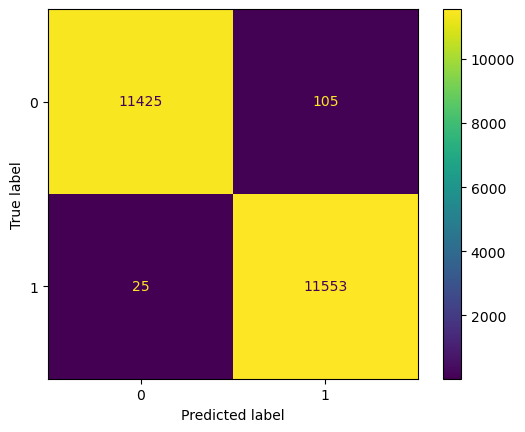

In [11]:
y_pred = tb_catb.predict(X_tb_validate)
print(classification_report(y_tb_validate, y_pred, digits=4))
print(classification_report(y_tb_validate, y_pred, digits=4), file=open("Outputs/CATB/"+MODEL_FILENAME+"_CATB_TB_ClassReport.txt", mode='w'))
disp = ConfusionMatrixDisplay(confusion_matrix(y_tb_validate, y_pred))
disp.plot()
plt.savefig("Outputs/CATB/"+MODEL_FILENAME+"_CATB_TB_"+"_ConfMatrix.png")

### 2.2.3. Preview of the Tree

*How can it be a tree if there is no proof of a tree?*

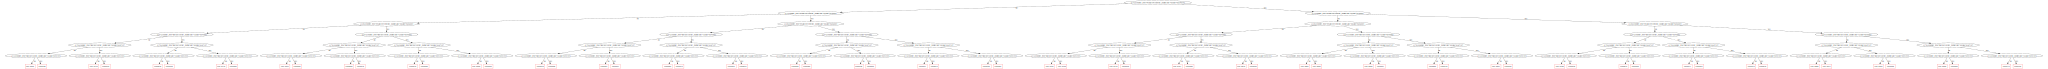

In [12]:
tree = tb_catb.plot_tree(0, catboost.Pool(X_tb_training, y_tb_training, cat_features=get_indexes(), feature_names=list(X_tb_training.columns)))
tree.save("Outputs/CATB/"+MODEL_FILENAME+"_CATB_TREE/TB_Tree"+".svg")
display(tree)

## 2.3. Training on Instance-Based Behaviors

### 2.3.1 Training Model

In [13]:
#Training Model
start_time()
ib_catb = setup_model(IB_HYPERPARAMS, "IB")
ib_catb.fit(X_ib_training, y_ib_training, plot=True, eval_set=catboost.Pool(X_ib_validate, label=y_ib_validate, cat_features=get_indexes()))
end_time("CATB_IB")

#Saving Model as file
ib_catb.save_model("Outputs/CATB/"+MODEL_FILENAME+"_CATB_IB.model", format="json")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


0:	learn: 0.4259541	test: 0.4257153	best: 0.4257153 (0)	total: 196ms	remaining: 48.7s
1:	total: 369ms	remaining: 45.8s
2:	total: 552ms	remaining: 45.5s
3:	total: 735ms	remaining: 45.2s
4:	total: 922ms	remaining: 45.2s
5:	learn: 0.0674905	test: 0.0674995	best: 0.0674995 (5)	total: 1.1s	remaining: 44.9s
6:	total: 1.29s	remaining: 45s
7:	total: 1.47s	remaining: 44.6s
8:	total: 1.66s	remaining: 44.4s
9:	total: 1.84s	remaining: 44.1s
10:	learn: 0.0347353	test: 0.0354319	best: 0.0354319 (10)	total: 2.03s	remaining: 44.1s
11:	total: 2.21s	remaining: 43.8s
12:	total: 2.39s	remaining: 43.6s
13:	total: 2.57s	remaining: 43.3s
14:	total: 2.76s	remaining: 43.3s
15:	learn: 0.0263766	test: 0.0276141	best: 0.0276141 (15)	total: 2.96s	remaining: 43.3s
16:	total: 3.14s	remaining: 43s
17:	total: 3.31s	remaining: 42.7s
18:	total: 3.49s	remaining: 42.4s
19:	total: 3.67s	remaining: 42.2s
20:	learn: 0.0232766	test: 0.0252819	best: 0.0252819 (20)	total: 3.85s	remaining: 42s
21:	total: 4.03s	remaining: 41.8s
2

183:	total: 33s	remaining: 11.8s
184:	total: 33.2s	remaining: 11.7s
185:	learn: 0.0116973	test: 0.0185791	best: 0.0185789 (180)	total: 33.3s	remaining: 11.5s
186:	total: 33.5s	remaining: 11.3s
187:	total: 33.7s	remaining: 11.1s
188:	total: 33.8s	remaining: 10.9s
189:	total: 34s	remaining: 10.7s
190:	learn: 0.0116622	test: 0.0185684	best: 0.0185684 (190)	total: 34.2s	remaining: 10.6s
191:	total: 34.4s	remaining: 10.4s
192:	total: 34.5s	remaining: 10.2s
193:	total: 34.7s	remaining: 10s
194:	total: 34.9s	remaining: 9.83s
195:	learn: 0.0116551	test: 0.0185633	best: 0.0185633 (195)	total: 35s	remaining: 9.65s
196:	total: 35.2s	remaining: 9.47s
197:	total: 35.3s	remaining: 9.28s
198:	total: 35.5s	remaining: 9.1s
199:	total: 35.7s	remaining: 8.92s
200:	learn: 0.0116489	test: 0.0185590	best: 0.0185590 (200)	total: 35.9s	remaining: 8.74s
201:	total: 36s	remaining: 8.56s
202:	total: 36.2s	remaining: 8.38s
203:	total: 36.3s	remaining: 8.19s
204:	total: 36.5s	remaining: 8.01s
205:	learn: 0.0116310

### 2.3.2. Checking Performance

Using the split for validation for a bit of internal checking of performance (i.e., not official)

              precision    recall  f1-score   support

           0     0.9981    0.9917    0.9949     11530
           1     0.9918    0.9981    0.9949     11578

    accuracy                         0.9949     23108
   macro avg     0.9949    0.9949    0.9949     23108
weighted avg     0.9949    0.9949    0.9949     23108



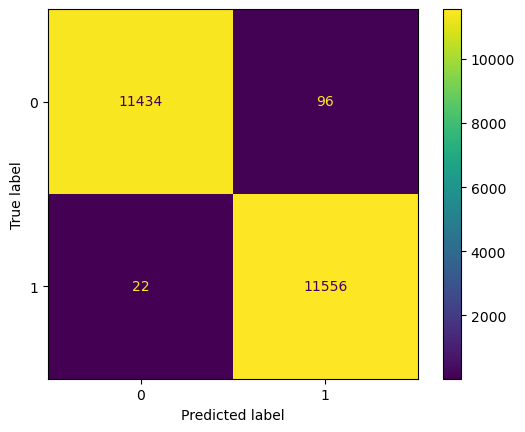

In [14]:
y_pred = ib_catb.predict(X_ib_validate)
print(classification_report(y_ib_validate, y_pred, digits=4))
print(classification_report(y_ib_validate, y_pred, digits=4), file=open("Outputs/CATB/"+MODEL_FILENAME+"_CATB_IB_ClassReport.txt", mode='w'))
disp = ConfusionMatrixDisplay(confusion_matrix(y_ib_validate, y_pred))
disp.plot()
plt.savefig("Outputs/CATB/"+MODEL_FILENAME+"_CATB_IB_"+"_ConfMatrix.png")

### 2.3.3. Preview of the Tree

*How can it be a tree if there is no proof of a tree?*

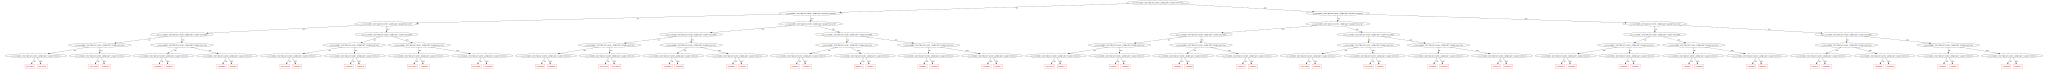

In [15]:
tree = ib_catb.plot_tree(0, catboost.Pool(X_ib_training, y_ib_training, cat_features=get_indexes(), feature_names=list(X_ib_training.columns)))
tree.save("Outputs/CATB/"+MODEL_FILENAME+"_CATB_TREE/IB_Tree"+".svg")
tree

In [16]:
logging("\n")